In [6]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from glob import glob

In [7]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

Num GPUs Available:  0
TensorFlow version:  2.18.0


### Build AlexNet from scratch

In [8]:
def AlexNet(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid')(inputs)
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x)

    x = Conv2D(256, (5, 5), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x)

    x = Conv2D(384, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)

    model = Model(inputs=inputs, outputs=x, name="AlexNet")
    return model

alexnet = AlexNet()

feature_extractor = Model(inputs=alexnet.input, outputs=alexnet.output)

feature_extractor.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,281,344 (222.33 MB)

 Trainable params: 58,281,344 (222.33 MB)

 Non-trainable params: 0 (0.00 B)

### Use AlexNet to extract features

In [9]:
def extract_features(image_paths, model, target_size=(227, 227)):
    features = []
    labels = []

    for img_path, label in image_paths:
        img = load_img(img_path, target_size=target_size) 
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  

        feature = model.predict(img)  
        feature = feature.flatten() 
        
        features.append(feature)
        labels.append(label)

    return np.array(features), np.array(labels)

In [10]:
train_dir = "../data/train"
val_dir = "../data/val"
test_dir = "../data/test"

def load_image_paths(folder, label):
    return [(img_path, label) for img_path in glob(os.path.join(folder, "*.jpg"))]

train_black = load_image_paths(os.path.join(train_dir, "black"), 1)
train_no_black = load_image_paths(os.path.join(train_dir, "no_black"), 0)
val_black = load_image_paths(os.path.join(val_dir, "black"), 1)
val_no_black = load_image_paths(os.path.join(val_dir, "no_black"), 0)
test_black = load_image_paths(os.path.join(test_dir, "black"), 1)
test_no_black = load_image_paths(os.path.join(test_dir, "no_black"), 0)

train_data = train_black + train_no_black
val_data = val_black + val_no_black
test_data = test_black + test_no_black

X_train, y_train = extract_features(train_data, feature_extractor)
X_val, y_val = extract_features(val_data, feature_extractor)
X_test, y_test = extract_features(test_data, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━

### Use SVM (default parameters) for classification

In [11]:
model = SVC()
model.fit(X_train, y_train)

SVC()

- val set

In [12]:
y_pred = model.predict(X_val)

Accuracy: 0.8833

Classification Report:
               precision    recall  f1-score   support

No Black (0)       0.87      0.90      0.89        30
   Black (1)       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



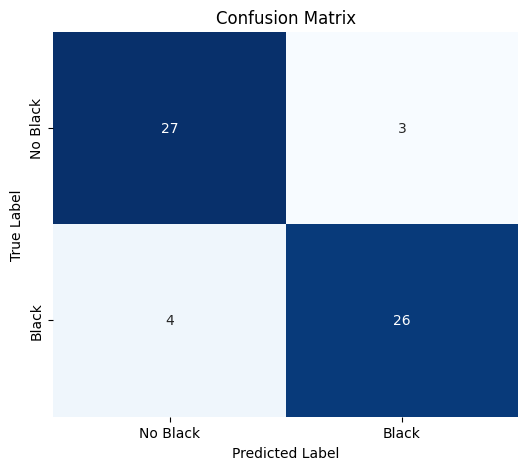

In [13]:
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=["No Black (0)", "Black (1)"])
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Black', 'Black'], yticklabels=['No Black', 'Black'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

- test set

In [14]:
y_pred = model.predict(X_test)

Accuracy: 0.9167

Classification Report:
               precision    recall  f1-score   support

No Black (0)       0.93      0.90      0.92        30
   Black (1)       0.90      0.93      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



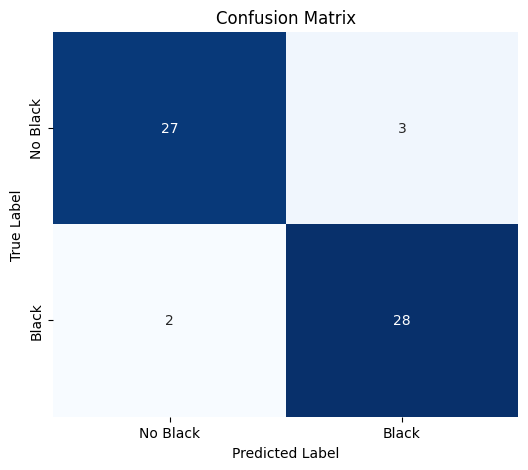

In [15]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["No Black (0)", "Black (1)"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Black', 'Black'], yticklabels=['No Black', 'Black'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()